In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime, timedelta

color_palette = sns.color_palette("Spectral", n_colors=7, desat=0.75)
sns.set_palette(color_palette)
plt.style.use("Solarize_Light2")

eth = yf.Ticker("ETH-USD")

In [2]:
today = datetime.now()
start_date = today - timedelta(days=728)
trends_data = pd.read_csv("Datasets/multiTimeline.csv")
trends_data = trends_data.drop(trends_data.index[0])
trends_data["goog_trend"] = pd.to_numeric(
    trends_data["Category: All categories"], errors="coerce"
)
del trends_data["Category: All categories"]
trends_data.index = pd.to_datetime(trends_data.index).tz_localize(None)
trends_data = trends_data.resample("H").asfreq()
trends_data["goog_trend"] = trends_data["goog_trend"].ffill()
df = eth.history(start=start_date, end=today, interval="1h")
df.index = pd.to_datetime(df.index).tz_localize(None)
del df["Dividends"]
del df["Stock Splits"]
del df["Volume"]
df.columns = [c.lower() for c in df.columns]
df["4_hr_future"] = df["close"].shift(-4)
df["target"] = (df["4_hr_future"] > df["close"]).astype(int)
df = df.merge(trends_data, left_index=True, right_index=True, how="left")

In [3]:
horizons = [2, 4, 6, 12, 18, 24, 36, 48, 72]
for i, horizon in enumerate(horizons):
    rolling_avg = df["close"].rolling(window=horizon).mean()
    df[f"close_ratio_{i}"] = df["close"] / rolling_avg
    df[f"trend_{i}"] = df["target"].shift(1).rolling(window=horizon).sum()
    df[f"pct_chg_close_{i}"] = df["close"].pct_change(periods=horizon)

In [4]:
def create_features(df):
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    df["dayofmonth"] = df.index.day
    df["weekofyear"] = df.index.isocalendar().week
    return df


def add_lags(df):
    target_map = df["close"].to_dict()
    df["lag1"] = (df.index - pd.Timedelta("4 hours")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("6 hours")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("12 hours")).map(target_map)
    return df


df = add_lags(df)
df = create_features(df)
df = df.reindex(sorted(df.columns), axis=1)
df.columns

Index(['4_hr_future', 'close', 'close_ratio_0', 'close_ratio_1',
       'close_ratio_2', 'close_ratio_3', 'close_ratio_4', 'close_ratio_5',
       'close_ratio_6', 'close_ratio_7', 'close_ratio_8', 'dayofmonth',
       'dayofweek', 'dayofyear', 'goog_trend', 'high', 'hour', 'lag1', 'lag2',
       'lag3', 'low', 'month', 'open', 'pct_chg_close_0', 'pct_chg_close_1',
       'pct_chg_close_2', 'pct_chg_close_3', 'pct_chg_close_4',
       'pct_chg_close_5', 'pct_chg_close_6', 'pct_chg_close_7',
       'pct_chg_close_8', 'quarter', 'target', 'trend_0', 'trend_1', 'trend_2',
       'trend_3', 'trend_4', 'trend_5', 'trend_6', 'trend_7', 'trend_8',
       'weekofyear', 'year'],
      dtype='object')

In [5]:
sorted_columns = [
    "close",
    "high",
    "low",
    "open",
    "pct_chg_close_0",
    "pct_chg_close_1",
    "pct_chg_close_2",
    "pct_chg_close_3",
    "pct_chg_close_4",
    "pct_chg_close_5",
    "pct_chg_close_6",
    "pct_chg_close_7",
    "pct_chg_close_8",
    "close_ratio_0",
    "close_ratio_1",
    "close_ratio_2",
    "close_ratio_3",
    "close_ratio_4",
    "close_ratio_5",
    "close_ratio_6",
    "close_ratio_7",
    "close_ratio_8",
    "trend_0",
    "trend_1",
    "trend_2",
    "trend_3",
    "trend_4",
    "trend_5",
    "trend_6",
    "trend_7",
    "trend_8",
    "lag1",
    "lag2",
    "lag3",
    "hour",
    "month",
    "quarter",
    "year",
    "dayofmonth",
    "dayofweek",
    "dayofyear",
    "weekofyear",
    "goog_trend",
    "4_hr_future",
    "target",
]
df = df.reindex(columns=sorted_columns)
del df["weekofyear"]
del df["high"]
del df["low"]
del df["open"]
del df["month"]
del df["year"]
df_features = [col for col in df.columns if col not in ["4_hr_future", "target"]]

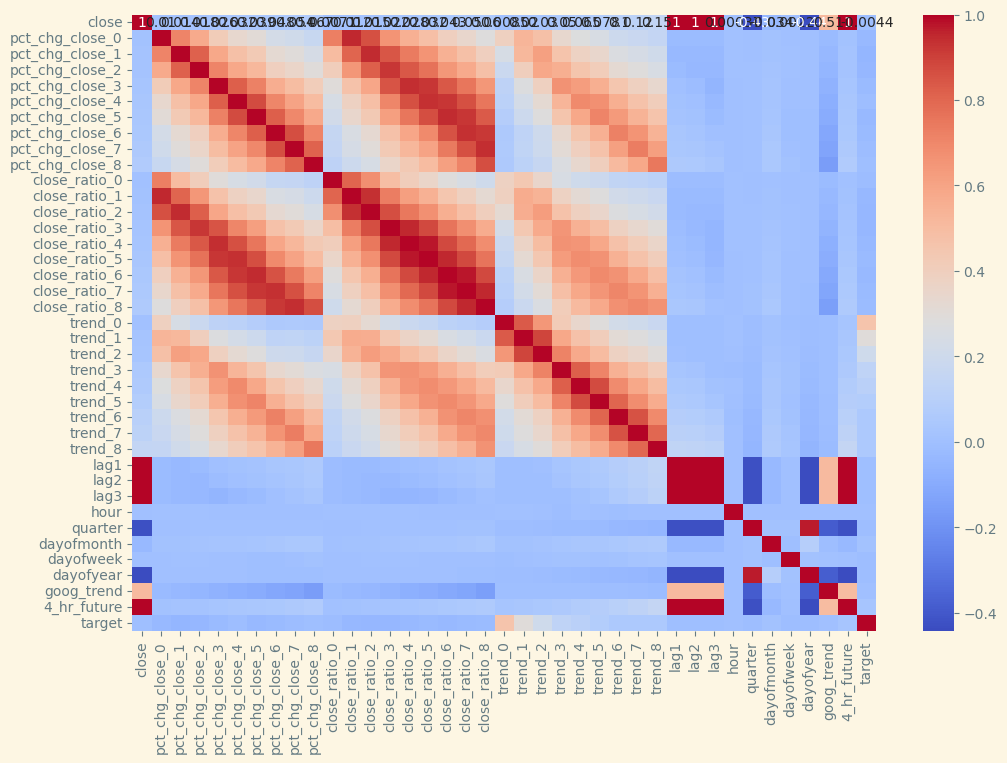

In [6]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

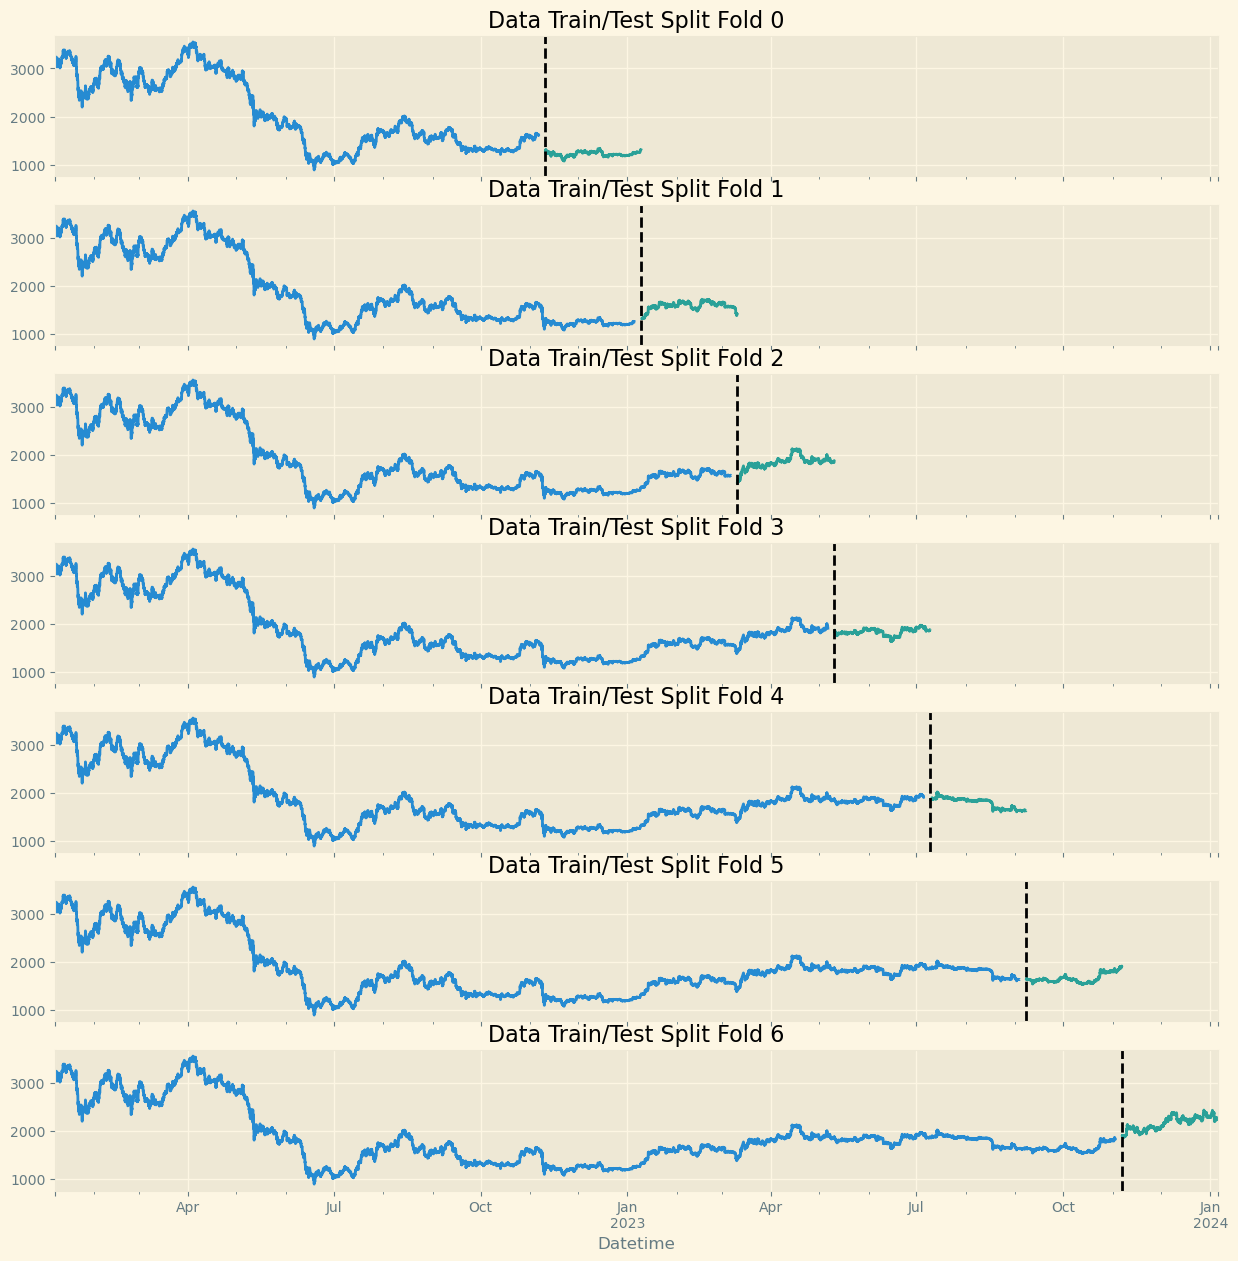

In [7]:
tss = TimeSeriesSplit(n_splits=7, test_size=24 * 60, gap=96)
df = df.sort_index()

fig, axs = plt.subplots(7, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train["close"].plot(
        ax=axs[fold], label="Training Set", title=f"Data Train/Test Split Fold {fold}"
    )
    test["close"].plot(ax=axs[fold], label="Test Set")
    axs[fold].axvline(test.index.min(), color="black", ls="--")
    fold += 1
plt.show()

In [8]:
def train_and_evaluate(df, features, target, model_params, n_splits, test_size, gap, verbose=250):
    """
    Train and evaluate XGBoost model using TimeSeriesSplit.

    :param df: DataFrame containing the dataset
    :param features: List of feature column names
    :param target: Name of the target column
    :param model_params: Dictionary of model parameters
    :param n_splits: Number of splits for TimeSeriesSplit
    :param test_size: Size of the test set for each split
    :param gap: Gap size between training and test set
    :return: Dictionary of average scores across all folds
    """
    tss = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap=gap)
    df = df.sort_index()
    df = df.astype("float64")

    accuracies, f1_scores, roc_aucs, precisions, recalls = [], [], [], [], []

    for fold, (train_idx, val_idx) in enumerate(tss.split(df)):
        train, test = df.iloc[train_idx], df.iloc[val_idx]
        X_train, y_train = train[features], train[target]
        X_test, y_test = test[features], test[target]

        classifier = xgb.XGBClassifier(**model_params)
        classifier.fit(
            X_train,
            y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=verbose,
        )

        y_pred = classifier.predict(X_test)

        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        accuracies.append(acc)
        f1_scores.append(f1)
        roc_aucs.append(roc_auc)
        precisions.append(precision)
        recalls.append(recall)

        print(
            f"Fold {fold}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}, ROC-AUC = {roc_auc:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}"
        )

        plt.figure(figsize=(6, 5))
        sns.heatmap(
            confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="coolwarm"
        )
        plt.title(f"Confusion Matrix for Fold {fold}")
        plt.show()

    print( {
        "Average Accuracy": np.mean(accuracies),
        "Average F1 Score": np.mean(f1_scores),
        "Average ROC-AUC": np.mean(roc_aucs),
        "Average Precision": np.mean(precisions),
        "Average Recall": np.mean(recalls),
    })
    
    return classifier

[0]	validation_0-logloss:0.69277	validation_1-logloss:0.69280


[2500]	validation_0-logloss:0.43432	validation_1-logloss:0.51125
[3313]	validation_0-logloss:0.41670	validation_1-logloss:0.50984
Fold 0: Accuracy = 0.7646, F1 Score = 0.7686, ROC-AUC = 0.8281, Precision = 0.7639, Recall = 0.7734


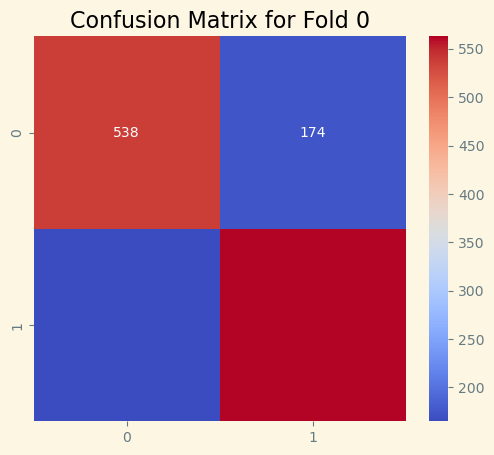

[0]	validation_0-logloss:0.69278	validation_1-logloss:0.69280
[2500]	validation_0-logloss:0.43958	validation_1-logloss:0.50965
[4548]	validation_0-logloss:0.40324	validation_1-logloss:0.50633
Fold 1: Accuracy = 0.7549, F1 Score = 0.7557, ROC-AUC = 0.8331, Precision = 0.7510, Recall = 0.7604


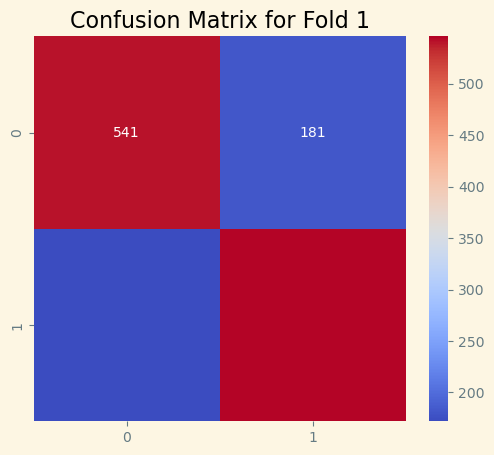

[0]	validation_0-logloss:0.69278	validation_1-logloss:0.69284
[2500]	validation_0-logloss:0.44631	validation_1-logloss:0.52421
[3947]	validation_0-logloss:0.41796	validation_1-logloss:0.52099
Fold 2: Accuracy = 0.7458, F1 Score = 0.7465, ROC-AUC = 0.8190, Precision = 0.7486, Recall = 0.7445


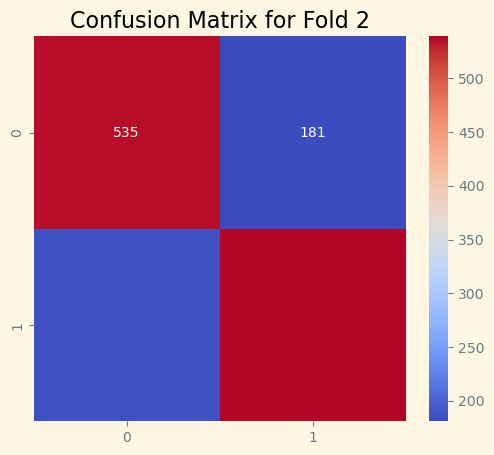

[0]	validation_0-logloss:0.69279	validation_1-logloss:0.69283
[2500]	validation_0-logloss:0.45223	validation_1-logloss:0.52115
[3538]	validation_0-logloss:0.43176	validation_1-logloss:0.51806
Fold 3: Accuracy = 0.7472, F1 Score = 0.7514, ROC-AUC = 0.8227, Precision = 0.7514, Recall = 0.7514


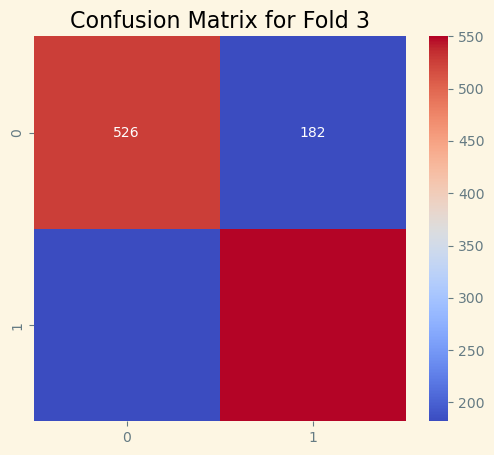

[0]	validation_0-logloss:0.69279	validation_1-logloss:0.69283
[2500]	validation_0-logloss:0.45889	validation_1-logloss:0.52309
[3306]	validation_0-logloss:0.44330	validation_1-logloss:0.52068
Fold 4: Accuracy = 0.7472, F1 Score = 0.7447, ROC-AUC = 0.8220, Precision = 0.7264, Recall = 0.7640


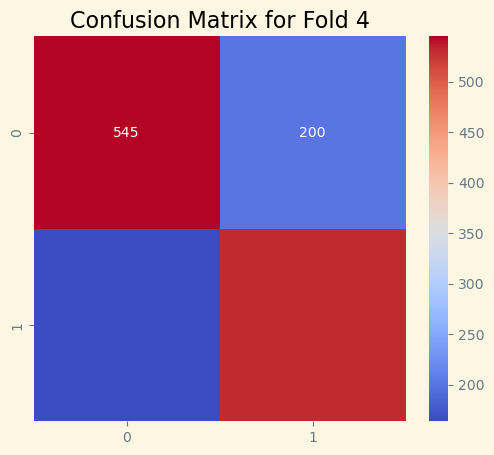

[0]	validation_0-logloss:0.69280	validation_1-logloss:0.69283
[2500]	validation_0-logloss:0.46450	validation_1-logloss:0.52167
[3759]	validation_0-logloss:0.44318	validation_1-logloss:0.51869
Fold 5: Accuracy = 0.7410, F1 Score = 0.7481, ROC-AUC = 0.8230, Precision = 0.7507, Recall = 0.7456


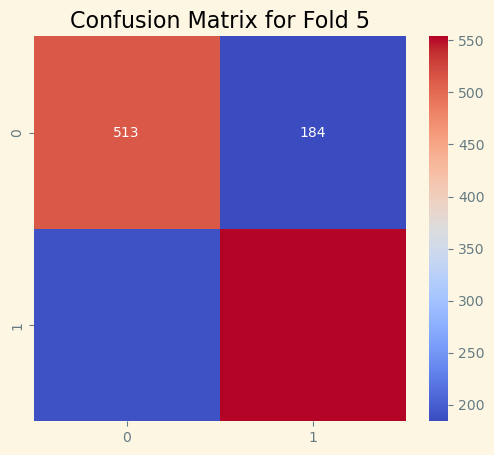

[0]	validation_0-logloss:0.69280	validation_1-logloss:0.69281
[2500]	validation_0-logloss:0.46785	validation_1-logloss:0.50355
[3216]	validation_0-logloss:0.45502	validation_1-logloss:0.50195
Fold 6: Accuracy = 0.7653, F1 Score = 0.7725, ROC-AUC = 0.8353, Precision = 0.7694, Recall = 0.7757


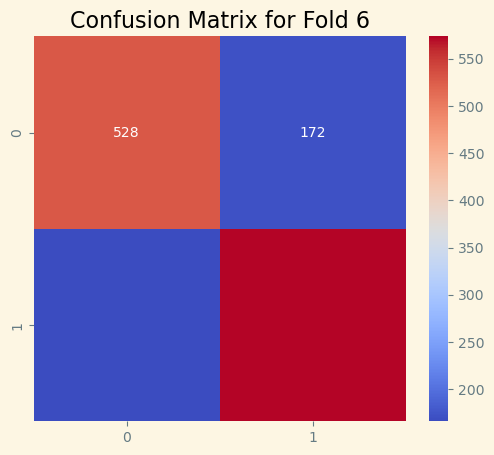

{'Average Accuracy': 0.7522817460317459, 'Average F1 Score': 0.7553772803664252, 'Average ROC-AUC': 0.8261630844089366, 'Average Precision': 0.7516333278752992, 'Average Recall': 0.7592812689973584}


In [9]:
model_params = {
    "random_state": 69,
    "learning_rate": 0.001,
    "n_estimators": 5000,
    "early_stopping_rounds": 100
}
num_splits = 7
test_size = 24*60
gap = 96

model = train_and_evaluate(df, df_features, "target", model_params, num_splits, test_size, gap, verbose=2500)

In [10]:
# tss = TimeSeriesSplit(n_splits=7, test_size=24 * 60, gap=96)
# df = df.sort_index()
# df = df.astype("float64")


# FEATURES = df_features
# TARGET = "target"

# fold = 0
# accuracies, f1_scores, roc_aucs, precisions, recalls = [], [], [], [], []
# for fold, (train_idx, val_idx) in enumerate(tss.split(df)):
#     train, test = df.iloc[train_idx], df.iloc[val_idx]
#     X_train, y_train = train[FEATURES], train[TARGET]
#     X_test, y_test = test[FEATURES], test[TARGET]

#     classifier = xgb.XGBClassifier(
#         random_state=69,
#         learning_rate=0.001,
#         n_estimators=2000,
#         early_stopping_rounds=100,
#     )
#     classifier.fit(
#         X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=250
#     )

#     y_pred = classifier.predict(X_test)

#     # Calculate metrics
#     acc = accuracy_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
#     roc_auc = roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])
#     precision = precision_score(y_test, y_pred)
#     recall = recall_score(y_test, y_pred)

#     accuracies.append(acc)
#     f1_scores.append(f1)
#     roc_aucs.append(roc_auc)
#     precisions.append(precision)
#     recalls.append(recall)
#     print(
#         f"Fold {fold}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}, ROC-AUC = {roc_auc:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}"
#     )
#     plt.figure(figsize=(6, 5))
#     sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="coolwarm")
#     plt.title(f"Confusion Matrix for Fold {fold}")
#     plt.show()

# print(f"Average Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
# print(f"Average F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
# print(f"Average ROC-AUC: {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f}")
# print(f"Average Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
# print(f"Average Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")

In [11]:
df.to_csv("training_set.csv")
correlation_matrix.to_csv("corr_matrix.csv")

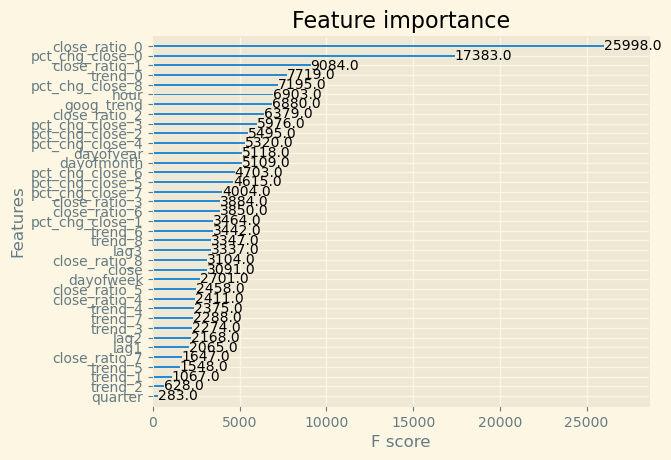

In [12]:
xgb.plot_importance(model)
plt.show()